### Importando dependências

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [171]:
# Definindo o DataFrame com os resultados das predições dos modelos
def build_dataframe(results):
    df = pd.DataFrame(results)
    df = df.sort_values(by=['roc','precision', 'recall'], ascending=False).reset_index(drop=True)
    return df

In [172]:
# Define o yhat, a matriz de confusão e os scores necessários para o modelo
def plot_confusion_matrix(model, X, y, model_name, model_desc):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title(model_name)
    
    data = {
        'model_name': model_name,
        'description': model_desc,
        'accuracy': round(accuracy_score(y, y_pred), 4),
        'precision': round(precision_score(y, y_pred), 4),
        'recall': round(recall_score(y, y_pred), 4),
        'roc': round(roc_auc_score(y, y_pred_prob), 4)
    }
    
    return data

### Lendo a base de dados

In [7]:
train_df = pd.read_csv("../dataset/train.csv")
test_df = pd.read_csv("../dataset/test.csv")

In [8]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
138,139,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C
781,782,1,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.0000,B20,S
458,459,1,2,"Toomey, Miss. Ellen",female,50.0,0,0,F.C.C. 13531,10.5000,NaN,S


In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Visualizing the data

In [10]:
train_df.shape

(891, 12)

In [11]:
#sns.countplot(dataset['Embarked'])

In [12]:
males = train_df[train_df.Sex == 'male']
females = train_df[train_df.Sex == 'female']

In [13]:
males_survived = males.Survived.value_counts().reset_index().rename(columns={'index': 'Survived', 'Survived': 'Count'})
males_survived['Sex'] = 'male'

females_survived = females.Survived.value_counts().reset_index().rename(columns={'index': 'Survived', 'Survived': 'Count'})
females_survived['Sex'] = 'female'

survived_per_sex = pd.concat([males_survived, females_survived], axis=0)

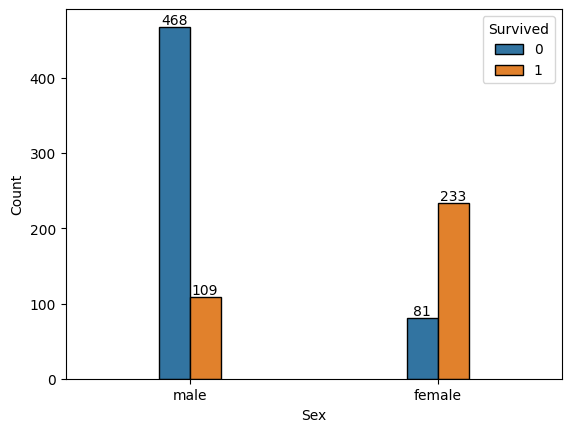

In [14]:
ax = sns.barplot(data=survived_per_sex, x='Sex', y='Count', hue='Survived', width=0.25, edgecolor='black')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

In [15]:
dead = train_df[train_df.Survived == 0].Pclass.value_counts().reset_index().rename(columns={'index': 'Pclass', 'Pclass': 'Count'})
dead['Survived'] = 0

survived = train_df[train_df.Survived == 1].Pclass.value_counts().reset_index().rename(columns={'index': 'Pclass', 'Pclass': 'Count'})
survived['Survived'] = 1

survived_per_pclass = pd.concat([dead, survived], axis=0)

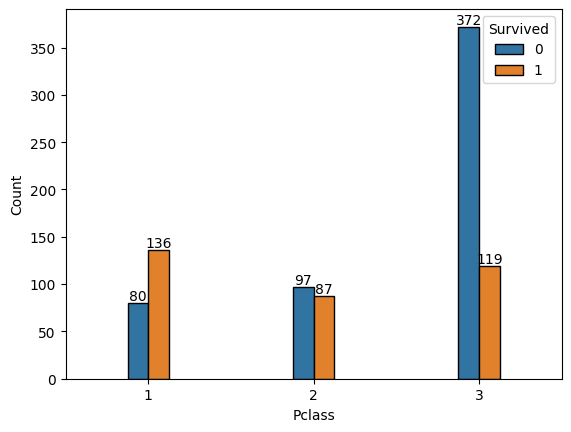

In [16]:
ax = sns.barplot(data=survived_per_pclass, x='Pclass', y='Count', hue='Survived', width=0.25, edgecolor='black')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

<Axes: xlabel='Age', ylabel='Fare'>

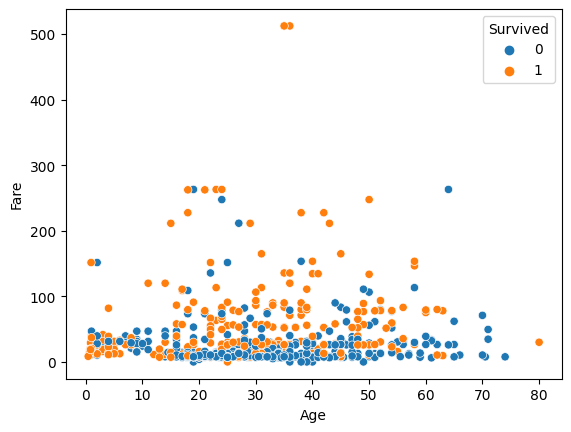

In [17]:
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived')

<Axes: xlabel='Age', ylabel='Count'>

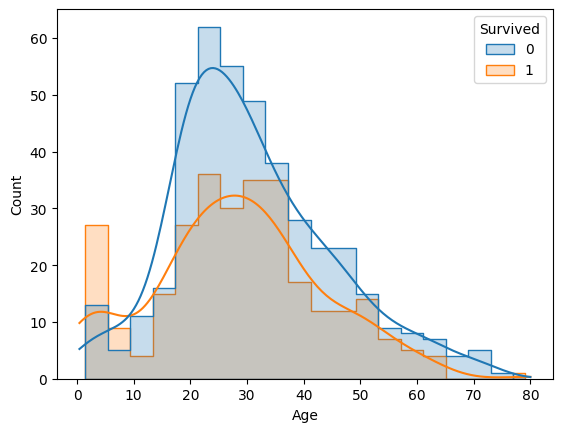

In [18]:
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='layer', shrink=0.5, kde=True, bins=20, element='step')

<Axes: xlabel='Age', ylabel='Count'>

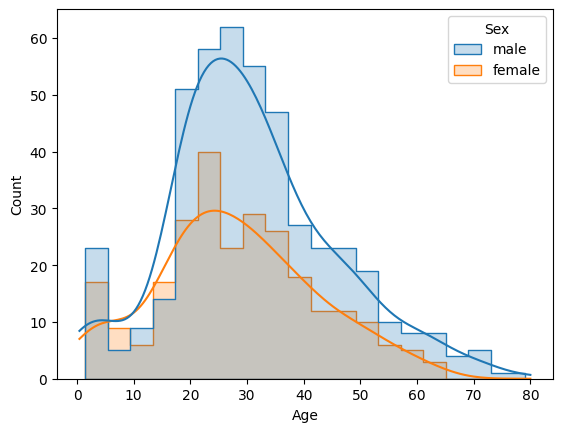

In [19]:
sns.histplot(data=train_df, x='Age', hue='Sex', multiple='layer', shrink=0.5, kde=True, bins=20, element='step')

<Axes: xlabel='Sex', ylabel='Age'>

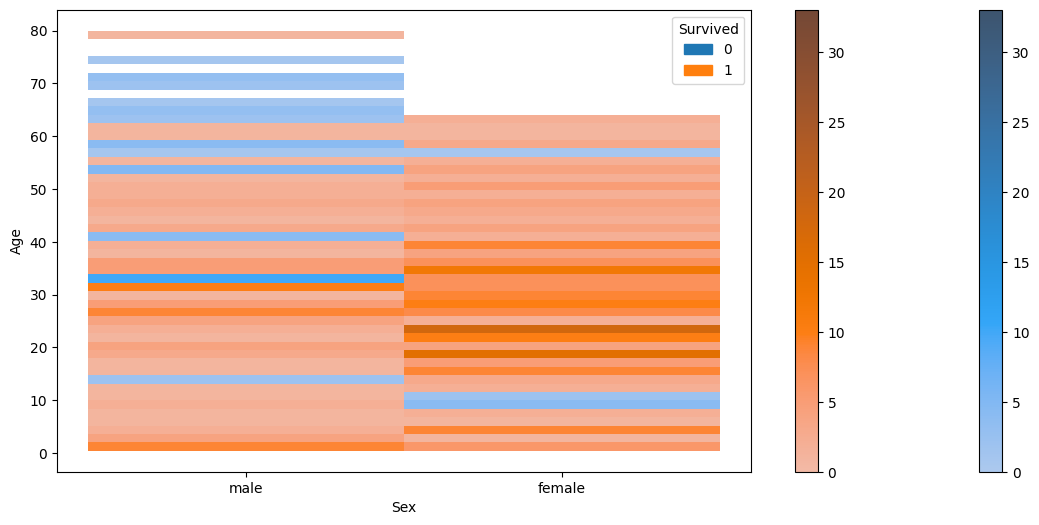

In [20]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(data=train_df, x='Sex', y='Age', hue='Survived', bins=50, cbar=True, ax=ax)

<Axes: xlabel='Sex', ylabel='Age'>

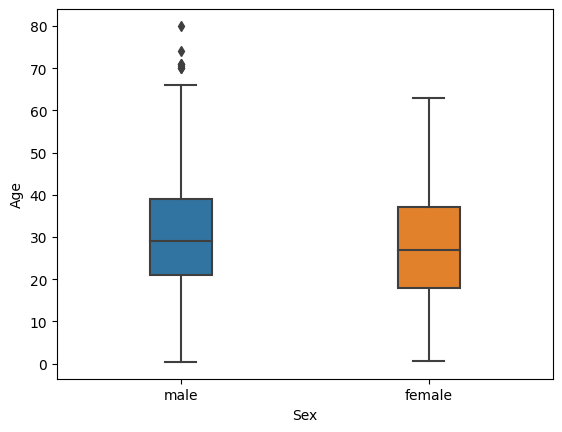

In [21]:
sns.boxplot(data=train_df, x='Sex', y='Age', width=0.25)

<Axes: xlabel='Survived', ylabel='Age'>

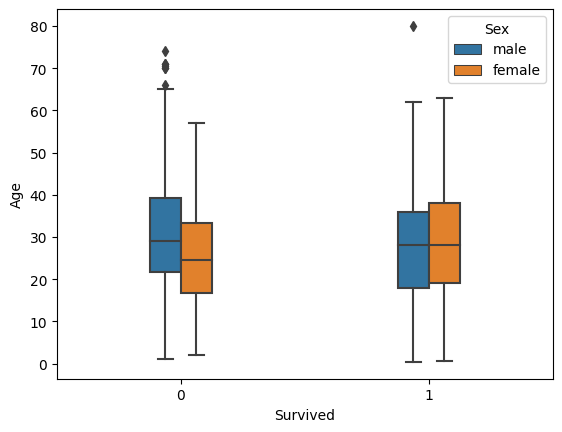

In [22]:
sns.boxplot(data=train_df, x='Survived', y='Age', hue='Sex', width=0.25)

<Axes: xlabel='Survived', ylabel='Fare'>

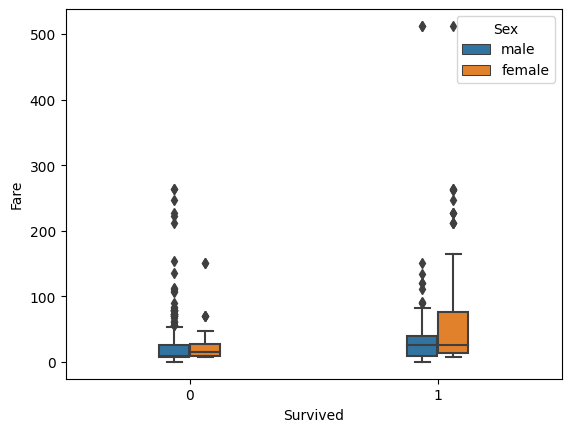

In [23]:
sns.boxplot(data=train_df, x='Survived', y='Fare', hue='Sex', width=0.25)

### Pré-processamento

In [24]:
percent = train_df.isnull().mean()
percent

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [25]:
most_null_cols = percent[percent > 0.75].index
train_df = train_df.drop(columns=most_null_cols)
train_df.sample(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
462,463,0,1,"Gee, Mr. Arthur H",male,47.0,0,0,111320,38.5,S


In [26]:
train_df = train_df.drop(columns=['PassengerId', 'Name','Ticket']) # useless features
#test_df = test_df.drop(columns=['PassengerId', 'Name','Cabin', 'Ticket'])

In [27]:
train_df.sample(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
552,0,3,male,NaN,0,0,7.8292,Q


In [29]:
# Matriz de features X e vetor TARGET y
X_ = train_df.loc[:, train_df.columns != 'Survived']
y_ = train_df.Survived

In [32]:
# Separando a base pré-processada em bases treino e teste
# seguindo uma proporção de 25% para a de teste
X_train, X_test, y_train, y_test = train_test_split(
X_, y_, test_size=0.25, random_state=42)

### Definindo a pipeline principal

In [174]:
types = X_.dtypes.reset_index()
types.columns = ['Feature', 'type']
types

,Feature,type
0,Pclass,int64
1,Sex,object
2,Age,float64
3,SibSp,int64
4,Parch,int64
5,Fare,float64
6,Embarked,object


In [30]:
CATEGORICAL_FEATURES = X_.select_dtypes(include='object').columns.tolist()
NUMERICAL_FEATURES = X_.select_dtypes(exclude='object').columns.tolist()

In [74]:
numerical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='mean')),
           ('scaler', MinMaxScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ]
)

In [75]:
pipe = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', DecisionTreeClassifier())
    ]
)

In [33]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator', DecisionTreeClassifier())])

In [34]:
pipe.score(X_test, y_test)

0.7174887892376681

### Utilizando GridSearchCV para buscar melhor configuração de hiperparâmetros

In [35]:
min_samples_leaf_range = [1, 5, 10, 15, 20, 25, 30]
min_samples_split_range = [2, 3, 4, 5, 6]
params = {'estimator__criterion': ['gini', 'entropy', 'log_loss'],
          'estimator__splitter': ['best', 'random'],
          'estimator__min_samples_leaf': min_samples_leaf_range,
          'estimator__min_samples_split': min_samples_split_range,
          'estimator__max_depth': [None, 3, 4, 5, 6],
          'estimator__max_leaf_nodes': [4, 6, 8, 10]}

In [36]:
tree_gscv = GridSearchCV(estimator=pipe, param_grid=params, verbose=True, scoring =['recall', 'roc_auc'], refit='recall').fit(X_train, y_train)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


In [37]:
tree_gscv

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked...
                                        DecisionTreeClassifier())]),
             param_grid={'estimator__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                         'estimator__max_depth': [None, 3, 4, 5, 6],
                         'estimator__max_leaf_nodes': [4, 6, 8, 10],
                         'estimator__min_samples_leaf': [1, 5, 10, 15, 20, 25,
                                                         30],
                         'estimator__min_samples_split': [2, 3, 4, 5, 6],
                         'estimator__splitter': ['best', 'random']},
             refit='recall', scoring=['recall', 'roc_auc'], verbose=True)

In [39]:
tree_gscv.scorer_

{'recall': make_scorer(recall_score, average=binary),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}

In [139]:
best_1 = tree_gscv.best_estimator_.steps[1][1]
best_1

DecisionTreeClassifier(max_leaf_nodes=6, min_samples_leaf=10)

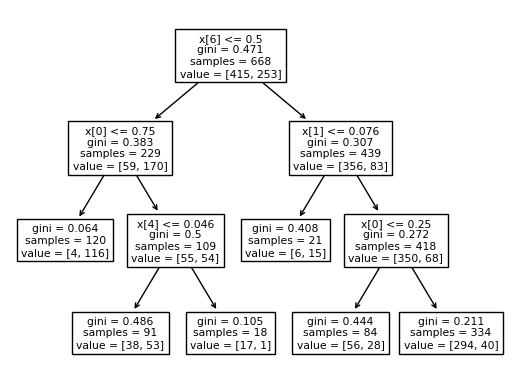

In [140]:
plot_tree(best_1)
plt.show()

In [38]:
tree_gscv.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_leaf_nodes': 6,
 'estimator__min_samples_leaf': 10,
 'estimator__min_samples_split': 2,
 'estimator__splitter': 'best'}

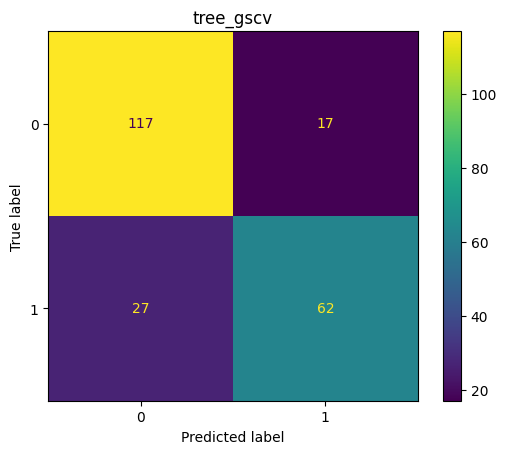

In [158]:
result_1 = plot_confusion_matrix(tree_gscv, X_test, y_test, 'tree_gscv', 'best decision tree with recall refit tuning')

In [159]:
result_1

{'model_name': 'tree_gscv',
 'description': 'best decision-tree with recall refit tuning',
 'accuracy': 0.8027,
 'precision': 0.7848,
 'recall': 0.6966,
 'roc': 0.8483}

In [47]:
tree_gscv_2 = GridSearchCV(estimator=pipe, param_grid=params, verbose=True, scoring=['recall', 'roc_auc'], refit='roc_auc').fit(X_train, y_train)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


In [108]:
tree_gscv_2

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked...
                                        DecisionTreeClassifier())]),
             param_grid={'estimator__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                         'estimator__max_depth': [None, 3, 4, 5, 6],
                         'estimator__max_leaf_nodes': [4, 6, 8, 10],
                         'estimator__min_samples_leaf': [1, 5, 10, 15, 20, 25,
                                                         30],
                         'estimator__min_samples_split': [2, 3, 4, 5, 6],
                         'estimator__splitter': ['best', 'random']},
             refit='roc_auc', scoring=['recall', 'roc_auc'], verbose=True)

In [109]:
tree_gscv_2.scorer_

{'recall': make_scorer(recall_score, average=binary),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}

In [141]:
best_2 = tree_gscv_2.best_estimator_.steps[1][1]
best_2

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=10,
                       min_samples_leaf=5, min_samples_split=5,
                       splitter='random')

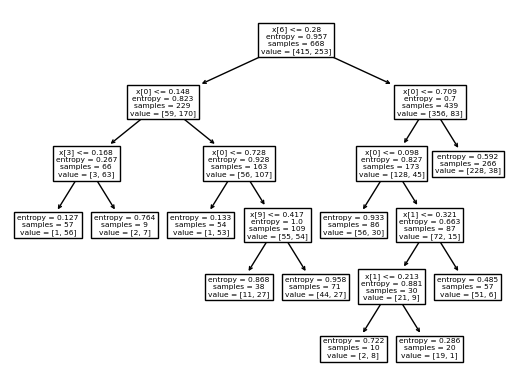

In [143]:
plot_tree(best_2)
plt.show()

In [48]:
tree_gscv_2.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator',
                 DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                        max_leaf_nodes=10, min_samples_leaf=5,
                                        min_samples_split=5,
                                        splitter='random'))])

In [110]:
tree_gscv_2.best_params_

{'estimator__criterion': 'entropy',
 'estimator__max_depth': 6,
 'estimator__max_leaf_nodes': 10,
 'estimator__min_samples_leaf': 5,
 'estimator__min_samples_split': 5,
 'estimator__splitter': 'random'}

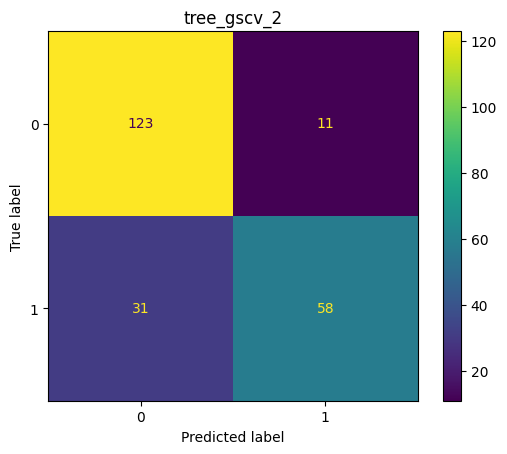

In [160]:
result_2 = plot_confusion_matrix(tree_gscv_2, X_test, y_test, 'tree_gscv_2', 'best decision tree with roc_auc refit tuning')

In [161]:
result_2

{'model_name': 'tree_gscv_2',
 'description': 'best decision-tree with roc_auc refit tuning',
 'accuracy': 0.8117,
 'precision': 0.8406,
 'recall': 0.6517,
 'roc': 0.8673}

### Utilizando random forests considerando as melhores decision trees encontradas com o GridSearch anteriormente

In [113]:
forest = RandomForestClassifier(max_leaf_nodes=6, min_samples_leaf=10, random_state=42)

forest_pipe = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', forest)
    ]
)

In [114]:
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator',
                 RandomForestClassifier(max_leaf_nodes=6, min_samples_leaf=10,
                                        random_state=42))])

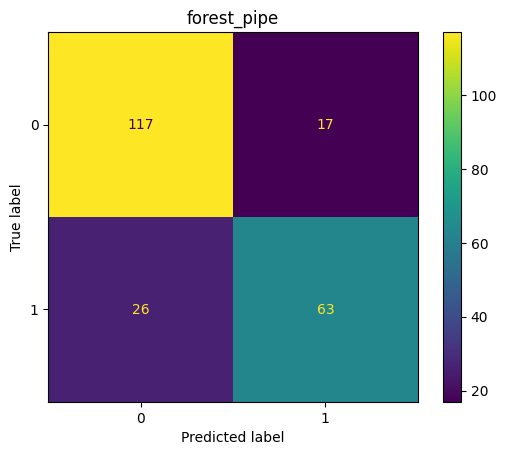

In [162]:
result_forest_1 = plot_confusion_matrix(forest_pipe, X_test, y_test, 'forest_pipe', 'random forest with tree_gscv hyperparameters')

In [163]:
result_forest_1

{'model_name': 'forest_pipe',
 'description': 'random forest with tree_gscv hyperparameters',
 'accuracy': 0.8072,
 'precision': 0.7875,
 'recall': 0.7079,
 'roc': 0.8712}

In [65]:
forest_2 = RandomForestClassifier(max_depth=6, criterion='entropy', max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=5, random_state=42)

forest_pipe_2 = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', forest_2)
    ]
)

In [66]:
forest_pipe_2.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator',
                 RandomForestClassifier(criterion='entropy', max_depth=6,
                                        max_leaf_nodes=10, min_samples_leaf=5,
                                        min_samples_split=5,
                                        random_state=42))])

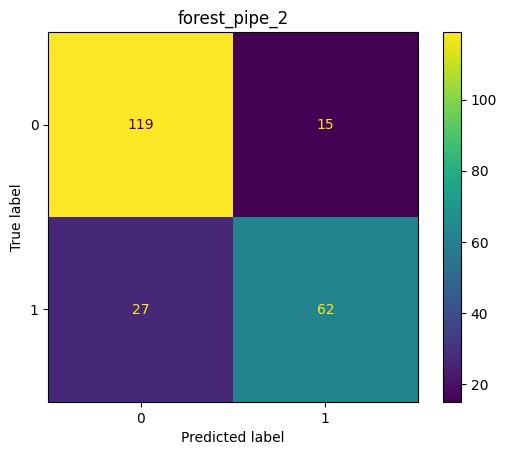

In [164]:
result_forest_2 = plot_confusion_matrix(forest_pipe_2, X_test, y_test, 'forest_pipe_2', 'random forest with tree_gscv_2 hyperparameters')

In [165]:
result_forest_2

{'model_name': 'forest_pipe_2',
 'description': 'random forest with tree_gscv_2 hyperparameters',
 'accuracy': 0.8117,
 'precision': 0.8052,
 'recall': 0.6966,
 'roc': 0.8803}

### Resultados finais no DataFrame

In [166]:
results = [result_1] + [result_2] + [result_forest_1] + [result_forest_2]

In [167]:
results = build_dataframe(results)
results

,model_name,description,accuracy,precision,recall,roc
0,forest_pipe_2,random forest with tree_gscv_2 hyperparameters,0.8117,0.8052,0.6966,0.8803
1,forest_pipe,random forest with tree_gscv hyperparameters,0.8072,0.7875,0.7079,0.8712
2,tree_gscv_2,best decision-tree with roc_auc refit tuning,0.8117,0.8406,0.6517,0.8673
3,tree_gscv,best decision-tree with recall refit tuning,0.8027,0.7848,0.6966,0.8483


### MLP

In [177]:
mlp = MLPClassifier(hidden_layer_sizes=(16,8), activation="tanh", random_state=42, max_iter=800)

mlp_pipe = Pipeline(
    steps=[('transformer', column_transformer),
           ('estimator', mlp)
    ]
)

In [178]:
mlp_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('estimator',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(16, 8),
                               max_iter=800, random_state=42))])

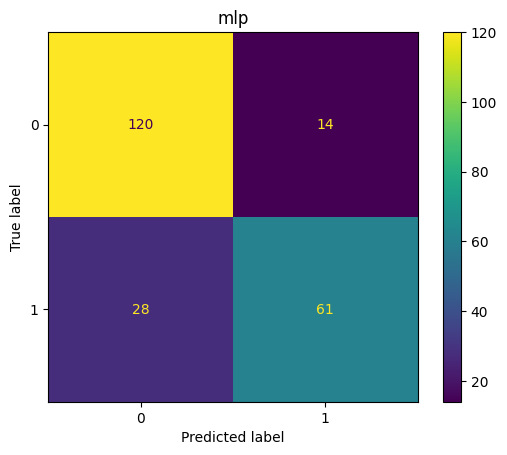

In [180]:
result_mlp = plot_confusion_matrix(mlp_pipe, X_test, y_test, 'mlp', 'multilayer perceptron')

In [181]:
result_mlp

{'model_name': 'mlp',
 'description': 'multilayer perceptron',
 'accuracy': 0.8117,
 'precision': 0.8133,
 'recall': 0.6854,
 'roc': 0.886}